## Inverse Cooking: Recipe Generation from Food Images

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args_old import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image, ImageFile
import time
import pandas as pd

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = '../data'

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [4]:
torch.cuda.is_available()

True

In [5]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [6]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [7]:
ingr_df = pd.DataFrame(ingrs_vocab)
ingr_df.head()

,0
0,<end>
1,macaroni
2,cheese
3,celery
4,pimentos


In [8]:
# instrs_df = pd.DataFrame(vocab)
# instrs_df.head()
vocab

{0: '<start>',
 1: '<end>',
 2: '<eoi>',
 3: 'cook',
 4: 'macaroni',
 5: 'according',
 6: 'to',
 7: 'package',
 8: 'directions',
 9: ';',
 10: 'drain',
 11: 'well',
 12: '.',
 13: 'cold',
 14: 'combine',
 15: ',',
 16: 'cheese',
 17: 'cubes',
 18: 'celery',
 19: 'green',
 20: 'pepper',
 21: 'and',
 22: 'pimento',
 23: 'blend',
 24: 'together',
 25: 'mayonnaise',
 26: 'or',
 27: 'possibly',
 28: 'salad',
 29: 'dressing',
 30: 'vinegar',
 31: 'salt',
 32: 'dill',
 33: 'weed',
 34: 'add',
 35: 'in',
 36: 'mix',
 37: 'toss',
 38: 'lightly',
 39: 'cover',
 40: 'refrigeratewell',
 41: 'serve',
 42: 'lettuce',
 43: 'lined',
 44: 'bowl',
 45: 'if',
 46: 'you',
 47: 'like',
 48: 'makes',
 49: '6',
 50: 'servings',
 51: 'dilly',
 52: 'recipe',
 53: 'the',
 54: 'tomatoes',
 55: 'a',
 56: 'food',
 57: 'processor',
 58: 'with',
 59: 'pinch',
 60: 'of',
 61: 'puree',
 62: 'until',
 63: 'smooth',
 64: 'onions',
 65: 'bell',
 66: 'peppers',
 67: 'cucumbers',
 68: 'tomato',
 69: 'large',
 70: 'chill',


In [11]:
# resize the image into a square with black padding
from PIL import Image, ImageOps

desired_size = 224
im_pth = "/home/eganlau/dev/inversecooking/data/demo_imgs/fittime/3.jpg"

im = Image.open(im_pth)
old_size = im.size  # old_size[0] is in (width, height) format
print(old_size)

ratio = float(desired_size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])
# use thumbnail() or resize() method to resize the input image
print(new_size)


# thumbnail is a in-place operation

# im.thumbnail(new_size, Image.ANTIALIAS)

im = im.resize(new_size, Image.ANTIALIAS)
im_resized = im.resize((desired_size,desired_size))

# create a new image and paste the resized on it

new_im = Image.new("RGB", (desired_size, desired_size))
new_im.paste(im, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))

# im_resized.show()
# im.show()
# new_im.show()

(1200, 1600)
(168, 224)


In [12]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/home/eganlau/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:47: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 4.39439582824707


In [13]:
args2 = get_parser()
print(args2.embed_size)
from torchvision.models import resnet18, resnet50
globals()['resnet50'](False)

512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [14]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [15]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [16]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs/fittime')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

In [17]:
image_folder
ImageFile.LOAD_TRUNCATED_IMAGES = True

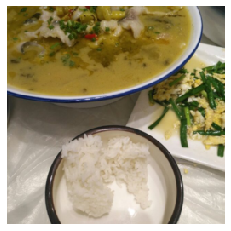

RECIPE 1

Title: Coconut curry soup

Ingredients:
onion, pepper, oil, salt, clove, milk, ginger, cilantro, water, curry

Instructions:
-Heat oil in a large saucepan over medium heat.
-Add onion and garlic and saute until soft, about 5 minutes.
-Add curry powder and ginger and cook for 1 minute.
-Add coconut milk and water and bring to a boil.
-Add salt and pepper to taste.
-Reduce heat and simmer for 10 minutes.
-Add cilantro and serve.
RECIPE 2

Title: Coconut curry chicken

Ingredients:
onion, pepper, oil, salt, clove, milk, ginger, cilantro, water, curry

Instructions:
-Combine coconut milk, water and oil in a large pot over medium heat.
-Stir in curry powder, garlic, ginger, onion, bell pepper and salt.
-Reduce heat to medium and cook until the onion has softened, about 5 minutes.
-Add the chicken pieces and cover.
-Cook, stirring occasionally, until chicken is no longer pink, about 5 minutes.
-Stir in coconut milk and cilantro.
-Continue cooking until the curry reaches desired thi

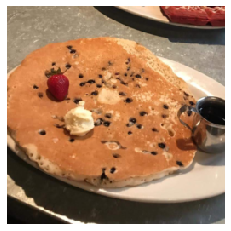

RECIPE 1

Title: Easy peasy mini pancakes

Ingredients:
sugar, flour, egg, salt, butter, baking_powder, milk, extract

Instructions:
-Preheat oven to 350 degrees f (175 degrees c).
-Grease a baking sheet.
-Whisk flour, baking powder, and salt together in a bowl.
-Beat milk, eggs, and vanilla extract together in a separate bowl; pour into flour mixture and stir until batter is just combined.
-Pour batter onto prepared baking sheet.
-Bake in the preheated oven until a toothpick inserted into the center of a pancake comes out clean, about 10 minutes.
RECIPE 2

Title: Pancakes

Ingredients:
sugar, flour, egg, salt, butter, baking_powder, milk, extract

Instructions:
-Beat eggs in a bowl; mix in sugar, vanilla, milk, and salt.
-In a separate bowl, combine flour, baking powder, and butter.
-Blend dry ingredients into liquid mixture.
-Batter will be thick.
-Grease a skillet.
-Drop 2 tablespoons batter onto hot skillet.
-Cook until bubbles form and edges begin to brown, then flip and cook othe

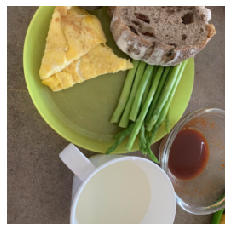

RECIPE 1

Title: Homemade onion soup mix

Ingredients:
salt, onion, pepper

Instructions:
-Combine all ingredients in a large bowl.
-Mix well.
-Store in an airtight container.
RECIPE 2

Title: Homemade taco sauce

Ingredients:
salt, onion, pepper

Instructions:
-Combine ingredients into saucepan.
-Mix well and cook over medium heat, stirring frequently, until mixture comes to a boil.
-Continue to cook until sauce reaches your desired consistency, stirring frequently to prevent sticking.
-Store in refrigerator until ready to use.
RECIPE 3

Title: Onion dip

Ingredients:
salt, onion, pepper

Instructions:
-Put all ingredients in food processor or blender.
-Put it on high and blend to desired consistency.
-Pour into a bowl and serve with veggies, breadsticks, etc.
RECIPE 4

Title: Spicy onion paste

Ingredients:
salt, onion, pepper

Instructions:
-Place the onion powder, salt, pepper, and cayenne pepper into the jar of a food processor, and turn on.
-Process for 20 seconds to a minute, sc

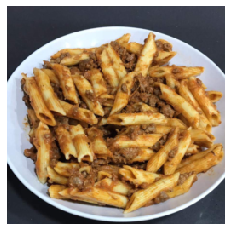

Not a valid recipe!
Reason:  no eos found
RECIPE 1

Title: Pasta in tomato sauce and corned beef

Ingredients:
cheese, pasta, pepper, onion, oil, beef, clove, tomato, salt

Instructions:
-Prepare pasta according to package directions; drain.
-Return pasta to pan.
-Meanwhile, heat oil in a medium skillet over medium heat.
-Add onion and garlic; cook, stirring occasionally, 5 minutes or until tender.
-Add beef; cook 5 minutes or until browned.
-Stir in undrained tomatoes with liquid, salt, and pepper.
-Cook over medium-high heat 2 minutes or until liquid almost evaporates.
-Stir in cooked pasta and 1 cup of the cheese.
-Remove from heat; cover.
-Let stand 1 to 2 minutes or until cheese melts.
-Sprinkle with remaining cheese.
RECIPE 2

Title: Pasta with ground beef and cheese

Ingredients:
cheese, pasta, pepper, onion, oil, beef, clove, tomato, salt

Instructions:
-In large skillet, heat oil over medium heat.
-Add onion; cook, stirring frequently, until translucent.
-Add minced beef; cook

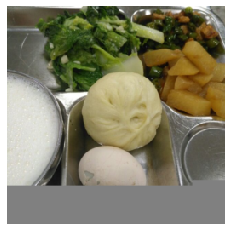

RECIPE 1

Title: Sweet potato and onion soup

Ingredients:
onion, pepper, potato, water, oil, salt, soy_sauce, clove

Instructions:
-Heat oil in a large pot over medium heat.
-Add onion and garlic and cook until soft, about 5 minutes.
-Add sweet potato and cook until tender, about 5 minutes.
-Add water, soy sauce, salt and pepper.
-Bring to a boil, reduce heat to low and simmer until sweet potato is tender, about 20 minutes.
RECIPE 2

Title: Japanese new potatoes in a pan

Ingredients:
onion, pepper, potato, water, oil, salt, soy_sauce, clove

Instructions:
-Slice the potatoes.
-Peel the onion and cut the garlic in half.
-Heat olive oil in a frying pan, and fry the potatoes.
-When the potatoes have softened, add the ingredients marked with and turn off the heat.
-When the potatoes are soft, transfer to a serving dish and sprinkle with white rice or shio-kombu.
-Done.
RECIPE 3

Title: Sweet potato

Ingredients:
onion, pepper, potato, water, oil, salt, soy_sauce, clove

Instructions:
-Pe

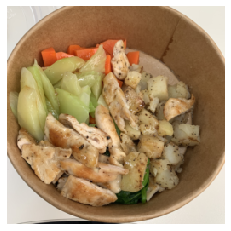

RECIPE 1

Title: Chicken with roasted vegetables

Ingredients:
chicken, pepper, oil

Instructions:
-Preheat oven to 425 degrees f. line a baking sheet with foil.
-Toss the chicken with the olive oil and season with salt and pepper.
-Spread the chicken on the baking sheet and roast for 20 minutes.
-Remove the chicken from the oven and toss the vegetables with the roasted chicken.
-Return to the oven and roast for another 10 minutes, or until the chicken is cooked through.
RECIPE 2

Title: Quick chicken tenders

Ingredients:
chicken, pepper, oil

Instructions:
-Heat oil in skillet on medium-high heat.
-Add chicken; cook 5 min.
-Add peppers; cook 5 min., turning chicken over after 5 min.
-Stir in dressing; cook and stir 2 min.
-Or until chicken is done.
RECIPE 3

Title: Easy sauteed chicken tenders

Ingredients:
chicken, pepper, oil

Instructions:
-Heat oil in large skillet on medium-high heat.
-Cook 3 min.
-On each side or until chicken is done (165 degrees f).
-Remove from skillet; cove

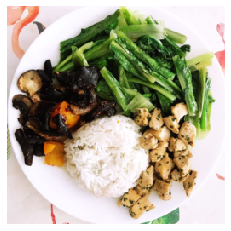

RECIPE 1

Title: Chicken with ginger and garlic

Ingredients:
oil, pepper, soy_sauce, clove, chicken, salt, onion, ginger

Instructions:
-Heat oil in a large skillet over medium-high heat.
-Add chicken and cook until browned on all sides, about 5 minutes.
-Add onion and garlic; cook and stir until onion is tender, about 5 minutes.
-Stir in ginger, soy sauce, and salt.
-Reduce heat to medium-low, cover, and simmer until chicken is cooked through, about 10 minutes.
RECIPE 2

Title: Chicken stir-fry with ginger and garlic

Ingredients:
oil, pepper, soy_sauce, clove, chicken, salt, onion, ginger

Instructions:
-In a large skillet, heat oil over high heat.
-Stir-fry chicken until golden; remove chicken and set aside.
-Add garlic and ginger to skillet and stir-fry 1 minute.
-Return chicken to skillet and add soy sauce, salt and pepper.
-Stir-fry 1 minute.
-Add green onions and stir-fry until crisp-tender and lightly browned.
RECIPE 3

Title: Grilled teriyaki chicken

Ingredients:
oil, pepper

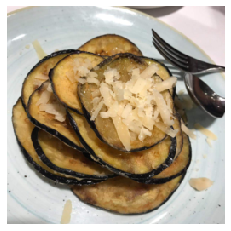

RECIPE 1

Title: Grilled eggplant and zucchini

Ingredients:
zucchini, oil, salt, pepper, squash, clove, eggplant

Instructions:
-Preheat grill to medium-high.
-Brush eggplant slices with olive oil and season with salt and pepper.
-Grill until tender, about 5 minutes per side.
-Transfer to a platter and let cool.
-Cut zucchini into 1/2-inch slices.
-Grill zucchini until tender, about 5 minutes per side.
-Transfer to a platter and drizzle with olive oil.
-Season with salt and pepper.
RECIPE 2

Title: Grilled eggplant and squash sauteed in zucchini, garlic, sea salt and olive oil

Ingredients:
zucchini, oil, salt, pepper, squash, clove, eggplant

Instructions:
-Cut a slice off the bottom of the zucchini.
-Slice off the ends, cut the slices in half lengthwise, and discard the top fourth.
-In a small bowl, combine 2 tablespoons olive oil, 1/4 teaspoon sea salt and 1/4 teaspoon pepper.
-Toss the vegetables in the mixture, and let sit at room temperature for 15 to 20 minutes.
-Preheat a gril

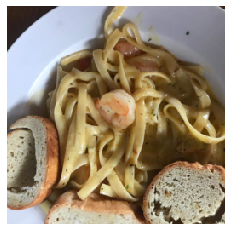

RECIPE 1

Title: Linguine with shrimp

Ingredients:
shrimp, pepper, butter, clove, oil, salt, linguine, parsley

Instructions:
-Cook pasta according to package directions.
-Drain.
-Meanwhile, in a large skillet, heat oil over medium heat.
-Add garlic and cook for 1 minute.
-Add shrimp and cook for 2 minutes or until shrimp turn pink.
-Stir in butter, parsley, salt and pepper.
-Toss with pasta.
RECIPE 2

Title: Quick & easy shrimp scampi

Ingredients:
shrimp, pepper, butter, clove, oil, salt, linguine, parsley

Instructions:
-Cook linguine according to directions; drain.
-Meanwhile, in large skillet over medium heat, heat oil.
-Add shrimp, garlic, salt and pepper; saute about 1 minute or until shrimp are pink, stirring occasionally.
-Add linguine, stir to coat, add butter to skillet.
-Toss to coat.
RECIPE 3

Title: Linguine with shrimp and garlic, parsley

Ingredients:
shrimp, pepper, butter, clove, oil, salt, linguine, parsley

Instructions:
-Cook linguine according to package directio

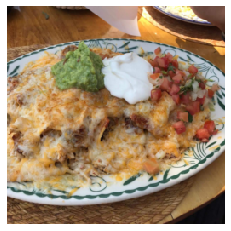

RECIPE 1

Title: Chicken enchiladas

Ingredients:
cheese, tortilla, onion, cream, enchilada_sauce, beans, chili, tomato, pepper, chicken, cumin, salt

Instructions:
-Preheat oven to 350 degrees f.
-In a large skillet, saute onion in oil until tender.
-Add chicken, beans, tomatoes, salt, pepper, chili powder, cumin and 1/2 cup of the cheese.
-Cook until heated through.
-Spoon about 1/4 cup of the chicken mixture down the center of each tortilla.
-Roll up and place seam side down in a greased 9x13 baking dish.
-Pour enchilada sauce over enchiladas.
-Sprinkle remaining cheese over top.
-Bake for 20 minutes or until cheese is melted.
RECIPE 2

Title: Enchilada bake

Ingredients:
cheese, tortilla, onion, cream, enchilada_sauce, beans, chili, tomato, pepper, chicken, cumin, salt

Instructions:
-Preheat the oven to 375 degrees f (190 degrees c).
-Lightly grease a 9x13 inch baking dish.
-Mix the enchilada sauce, sour cream, cumin, chili powder, cayenne pepper, and salt together in a large bowl

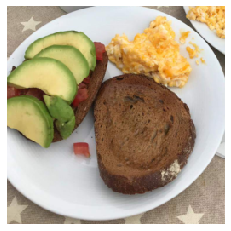

RECIPE 1

Title: Avocado egg toast

Ingredients:
avocado, bread, salt, egg, mayonnaise, pepper

Instructions:
-Toast bread.
-Spread mayonnaise on toast.
-Top with avocado.
-Sprinkle with salt and pepper.
RECIPE 2

Title: The perfect egg toast

Ingredients:
avocado, bread, salt, egg, mayonnaise, pepper

Instructions:
-Crack the eggs into a bowl, add the salt and pepper, and mash them with your fork or whisk.
-Add the mayonnaise, then whisk again.
-Place your bread on a baking sheet in a toaster oven to toast for about 5 minutes.
-Top with a few slices of avocado, then the egg mixture, and bake another 5 minutes, until the egg is done.
RECIPE 3

Title: Avocado egg salad sandwich

Ingredients:
avocado, bread, salt, egg, mayonnaise, pepper

Instructions:
-Mash the avocado.
-Add the other ingredients and mix.
RECIPE 4

Title: Avocado egg toast

Ingredients:
avocado, bread, salt, egg, mayonnaise, pepper

Instructions:
-Mash the avocado with a fork in a small bowl.
-Season to taste with salt 

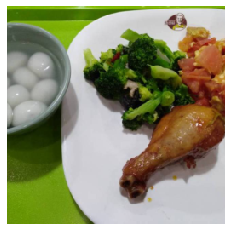

RECIPE 1

Title: Chicken wings with bacon

Ingredients:
chicken, soy_sauce, pepper, bacon

Instructions:
-Cut the chicken wings into bite-sized pieces.
-Season with salt and pepper.
-Wrap the chicken wings with bacon and secure with a toothpick.
-Heat a frying pan and cook the chicken wings until browned.
-Add the soy sauce and cook until the sauce has thickened.
RECIPE 2

Title: Chicken wings in soy sauce

Ingredients:
chicken, soy_sauce, pepper, bacon

Instructions:
-Wash the chicken wings, then cut them in half to make 4 sections.
-Boil the wings in salted water.
-Cut the bacon into 3 parts, then cut into thirds.
-Cut each piece lengthwise into quarters.
-Put the wings in a plastic bag, add soy sauce, and massage them to coat everything.
-Leave the wings at room temperature.
-Add the bacon fat, and massage it into the wings.
-Let it marinade for about 30 minutes.
-Add the chicken wings to it in the marinade and turn them over several times.
-Cook in an oven preheated to 200c for 20 

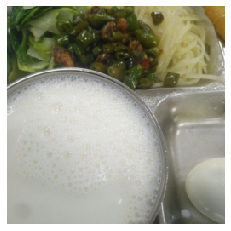

RECIPE 1

Title: Lemon coconut milk

Ingredients:
milk, juice, ice, water

Instructions:
-Put all ingredients in a blender and blend until smooth.
-Pour into a glass and enjoy !
RECIPE 2

Title: Refreshing lemon soda drink

Ingredients:
milk, juice, ice, water

Instructions:
-Put all ingredients in a blender and blend until smooth.
-Pour over a tall glass and enjoy !
RECIPE 3

Title: Lemon milk for one

Ingredients:
milk, juice, ice, water

Instructions:
-In a small container, mix all ingredients together and chill for several hours.
-Stir before serving.
RECIPE 4

Title: Lemon coconut milk substitute

Ingredients:
milk, juice, ice, water

Instructions:
-Pour the coconut milk into a blender.
-Add lemon juice and ice cubes and blend on high speed until foamy.
-Serve immediately.


In [18]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(256))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])
        